In [1]:
import matplotlib.pyplot as plt
import numpy as np

from datasets.mnist import MNIST

from models.cae_model import CAE
from models.conv_model import CNN

from train import train_ae, train_cnn
%load_ext autoreload

%aimport models.cem_ibm_model


import os
import time

In [2]:
dataset = MNIST(batch_size=64)
# dataset = FashionMNIST()

# Training the classifier

In [3]:
cnn = CNN(device='cuda:0')

train_cnn(cnn, dataset, iterations=25, lr=0.01, device='cuda:0', save_fn='mnist-cnn-m', load_path="models/saved_models/mnist-cnn-m.h5")

In [4]:
images, _ = dataset.get_batch()
cnn.cpu()
output = cnn(images)

images = images.numpy()
output = output.detach().numpy()


D:\Programmeren\uva-fact-ai\models\conv_model.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = nn.functional.softmax(out)


# Training the autoencoder

This section trains the autoencoder which will be used as regularizer for the data space which the perturbations are found in.

In [20]:
# Train or load autoencoder
cae = CAE(device='cuda:0')

train_ae(cae, dataset, iterations=3, device='cuda:0', save_fn="mnist-cae-m", load_path="models/saved_models/mnist-cae.h5")

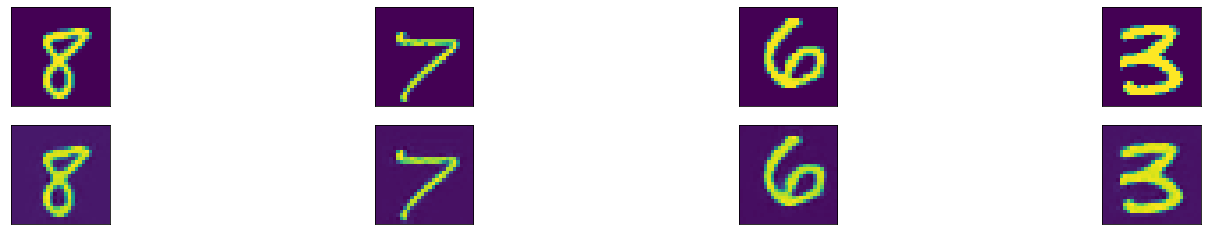

In [34]:
# obtain one batch of test images
images, _ = dataset.get_batch()

#images_flatten = images.view(images.size(0), -1)
# get sample outputs
cae.cpu()
output = cae(images+.5)
# prep images for display
images = images.cpu().numpy()

# output is resized into a batch of images
# output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.cpu().detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img))#, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

# Contrastive Explanation Method

In [69]:
%autoreload
kappa = 10
gamma = 10
beta = 0.5
lr = 0.1
cae.cpu()
cnn.cpu()

CEM = models.cem_ibm_model.AEADEN(model=cnn, AE=cae, max_iterations=300, evaluate_every=50, n_searches=4, mode="PN", init_learning_rate=lr, c_init=0.1, kappa=kappa, gamma=gamma, beta=beta)

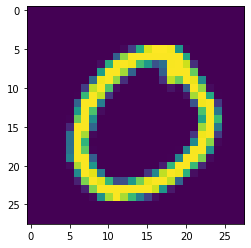

In [70]:
# obtain one sample
image, _ = dataset.get_sample()

plt.imshow(image.squeeze())


In [71]:
# find pertinent negatives
cnn.float()
CEM.compute_CEM(image)

search:0 iteration:  50 lr:0.09 c value:1.00E-01 loss: 1.88E+00 delta sum:-2.69E+02 optimum:False y grad:-2.955E+00
search:0 iteration: 100 lr:0.08 c value:1.00E-01 loss: 1.88E+00 delta sum:-2.69E+02 optimum:False y grad:-2.955E+00
search:0 iteration: 150 lr:0.07 c value:1.00E-01 loss: 1.88E+00 delta sum:-2.69E+02 optimum:False y grad:-2.955E+00
search:0 iteration: 200 lr:0.06 c value:1.00E-01 loss: 1.88E+00 delta sum:-2.69E+02 optimum:False y grad:-2.955E+00
search:0 iteration: 250 lr:0.04 c value:1.00E-01 loss: 1.88E+00 delta sum:-2.69E+02 optimum:False y grad:-2.955E+00
search:0 iteration: 300 lr:0.01 c value:1.00E-01 loss: 1.88E+00 delta sum:-2.69E+02 optimum:False y grad:-2.955E+00
doei
search:1 iteration:  50 lr:0.09 c value:1.00E+00 loss: 1.88E+01 delta sum:-2.69E+02 optimum:False y grad:6.119E+01
search:1 iteration: 100 lr:0.08 c value:1.00E+00 loss: 1.88E+01 delta sum:-2.69E+02 optimum:False y grad:6.119E+01
search:1 iteration: 150 lr:0.07 c value:1.00E+00 loss: 1.88E+01 delta

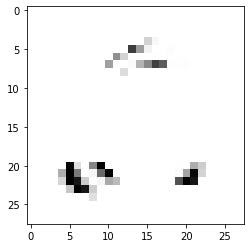

In [78]:
# perturbation
plt.imshow(image.squeeze()- CEM.delta_tracker[-1].view(28,28), cmap="gray")

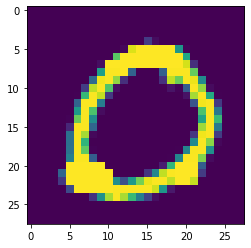

In [79]:
# original image with perturbation
plt.imshow(CEM.delta_tracker[-1].view(28,28))

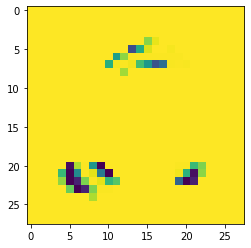

In [80]:
plt.imshow(image.view(28,28)-CEM.delta_tracker[-1].view(28,28))

In [81]:
# classification before
cnn.float()
before = np.argmax(cnn(image.squeeze(-1)).detach()).item()
before

0

In [82]:
cnn.double()
# classification after
after = np.argmax(cnn(CEM.delta_tracker[-1].view(1,28,28)).detach()).item()
after

2

In [85]:
# classification after
cnn.double()
# classification of delta
class_delta = np.argmax(cnn(image.squeeze(-1) - CEM.best_delta.view(1,28,28)).detach()).item()
class_delta

7

In [46]:
dirname = "saved_perturbations/kappa-{}-gamma-{}-beta-{}-lr-{}".format(kappa, gamma, beta, lr)
os.makedirs(dirname, exist_ok=True)
fname_orig = dirname + "/{}-cb-{}-ca-{}-orig.png".format(int(time.time()), before, after)
fname_pert = dirname + "/{}-before-{}-after-{}-pert.png".format(int(time.time()), before, after)
fname_combined = dirname + "/{}-before-{}-after-{}-pn.png".format(int(time.time()), before, after)
fname_combined_pp = dirname + "/{}-before-{}-after-{}-pp.png".format(int(time.time()), before, after)
plt.imsave(fname_orig, image.squeeze(), cmap="gray")
plt.imsave(fname_pert, CEM.best_delta.view(28,28) - image.squeeze(), cmap="gray")
plt.imsave(fname_combined, CEM.best_delta.view(28,28), cmap="gray")
plt.imsave(fname_combined_pp, image.squeeze() - CEM.best_delta.view(28,28))

In [47]:
print(CEM.best_loss)

AttributeError: 'AEADEN' object has no attribute 'best_loss'

In [ ]:
print(CEM.best_pert_loss)

In [ ]:
print(CEM.best_c)